# Ejemplo del satélite artificial: Aplicación del método RK4, y monitorización del error

<ul id="top">
<li><a href="#1-Implementación-del-método-de-Runge-Kutta-de-orden-4-(RK4)">1-Implementación del método de Runge-Kutta de orden 4 (RK4)</a></li>
<li><a href="#2-Comprobación-de-RK4-en-el-ejemplo-del-robot-móvil">2-Comprobación de RK4 en el ejemplo del robot móvil</a></li>
<li><a href="#3-Satélite-artificial-orbitando-alrededor-de-la-tierra:-Modelo-simplificado">3-Satélite artificial  orbitando alrededor de la tierra: Modelo simplificado</a></li>
<li><a href="#4-Satélite-artificial-orbitando-alrededor-de-la-tierra:-Modelo-más-realista">4-Satélite artificial  orbitando alrededor de la tierra: Modelo más realista</a></li>
<li><a href="#Valoración">Valoración</a></li>
</ul>  

In [1]:
using LinearAlgebra
using Plots
using DelimitedFiles

## 1-Implementación del método de Runge-Kutta de orden 4 (RK4)

Queremos simular numéricamente la evolución de sistemas modelados por 
ecuaciones diferenciales ordinarias (EDOs) de dimensión $d\geq 1$ de la forma

<a id='Edo-Compacta'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p). \hspace{10em} \tag{1}
\end{equation*}

donde $u =(u^1,\ldots,u^d) \in \mathbb{R}^d$ es el _vector de estado_ del sistema, y $p \in \mathbb{R}^m$ es un vector de parámetros constantes del sistema.

Sabemos que, fijado el vector $p$ de parámetros constantes, 
dados $t_0 \in \mathbb{R}$ y $u_0 =(u^1_0,\ldots,u^d_0) \in \mathbb{R}^d$, existe una única solución $u(t)$ de [(1)](#Edo-Compacta) que satisfaga la condición inicial

<a id='Cond-Ini'></a>
\begin{equation*}
  u(t_0)=u_0. \hspace{12em} \tag{2}
\end{equation*}

En la práctica, nos interesará calcular de forma aproximada la solución $u(t)$ para un cierto intervalo temporal $t \in [t_0,T]$. Se aproximará dicha solución en una discretización del tiempo obtenida de dividir el intervalo temporal $[t_0,T]$ en $n$ partes iguales. Es decir,  se tomará los valores discretos del tiempo $t_0,t_1,t_2,\ldots,t_{n-1},t_n=T$, donde $t_k=t_{0}+k h$, con $h=(T-t_0)/n$, y se calcularán las aproximaciones 
$u_k =(u^1_k,\ldots,u^d_k) \approx u(t_k)$ para $k=0,1,\ldots,n$.


Para realizar los ejercicios de simulación que siguen, se debe primeramente implementar el método RK4 en Julia. Se definirá una función (que llamaremos RK4) que toma como argumentos de entrada $u0, t0, T, n, f, p, m$.

El significado de los primeros seis argumentos de entrada de dicha función se puede deducir de las consideraciones de arriba. Como argumento de entrada adicional, se considerará un entero positivo $m$ cuyo significado se explicará a continuación, y cuyo valor por defecto será $m=1$. (Es decir, si cuando se invoca a la función RK4, se dan como argumentos de entrada $u0, t0, T, n, f, p$, se considerará que $m=1$.

Si $m=1$, ello indicará que para cada $j=1,\ldots,n$, se obtendrá la aproximación $u_j \approx u(t_j)$ aplicando un paso de longitud $h=(T-t_0)/n$ del método RK4. En cambio, si $m>1$, cada aproximación $u_j \approx u(t_j)$ se obtendrá aplicando $m$ pasos de longitud $h=(T-t_0)/(n m)$ del método RK4. Esto último será conveniente si sólo queremos los resultados para $n+1$ tiempos, pero la aproximación obtenida con el método de RK4 con $h=(T-t_0)/n$ no es suficientemente precisa.



El argumento de entrada $f$ es el nombre de una función previamente definida, tal que dados $t \in \mathbb{R}$, un vector $u \in \mathbb{R}^d$, y un vector de parámetros $p\in \mathbb{R}^m$,
devuelve un vector $f(t,u,p) \in \mathbb{R}^d$. Dicha función determina un sistema de EDOs de la forma [(1)](#Edo-Compacta).

La función RK4 debe devolver como argumento de salida una matriz $W \in \mathbb{R}^{(n+1) \times (d+1)}$

\begin{eqnarray*}
W = \left(
     \begin{array}{cccc}
t_0    &   u^1_0 & \cdots& u^d_0  \\
t_1    &    u^1_1 & \cdots& u^d_1  \\
\vdots &  \vdots & \vdots& \vdots \\
t_{n}  &      u^1_n & \cdots& u^d_n
     \end{array}
\right),
\end{eqnarray*} 

donde $t_k = t_0 + k \, h$, $h=(T-t_0)/n$, y los vectores $u_k  = (u^1_k,\ldots,u^d_k) \in \mathbb{R}^d$ ($k=1\ldots,n$) son aproximaciones de $u(t_k)$ que se han obtenido aplicando el método RK4 al sistema  [(1)](#Edo-Compacta) con la condición inicial  [(2)](#Cond-Ini) (con longitud de paso $h=(T-t_0)/(n m)$). 


In [2]:
function genCoef(s)
    
    b = 0.0 * zeros(s,1) 
    a = 0.0 *zeros(s,s-1) 
    c = 0.0 *zeros(s,1) 
    
    # coeficientes b    
    b[1] = 1/((s-1)*2)
    b[s] = b[1]
    for k in 2:s-1
        b[k] = b[1]*2
    end
        
    # coeficientes a
    for k in 2:s-1
        a[k,k-1] = 1/length(collect(2:s-1))
    end
    a[s,s-1] = sum(a[2:s-1,:])

    # coeficientes c
    for k in 1:size(a,1)
        c[k] = sum(a[k,1:s-1])    
    end

    return a,b,c
end

genCoef (generic function with 1 method)

In [3]:
function checkCoef(a,b,c)
    # Comprobamos que los coeficientes cumplen las siguientes condiciones:
    if round(sum(b)*1e6)/1e6 !=1.0
        print("coefficients out of range")
    end

    sm = 0.0
    for k in 1:s
        for l in 1:k-1
            sm = sm + b[k]*a[k,l]*c[l]
        end
    end
    if (sm != 1/6)
        print("coefficients out of range")
    end

    if ( (b'*c)[1]  != 1/2 ) || ( (b'*c.^2)[1]  != 1/3 )
        print("coefficients out of range")
    end
end

checkCoef (generic function with 1 method)

In [4]:
s = 4
a,b,c = genCoef(s)
checkCoef(a,b,c)


k1j = f( tj, uj, p )

k2j = f( tj+h*c[2], uj+h*a[2,1]*k1j, p )

k3j = f( tj+h*c[3], uj+h*a[3,1]*k1j+h*a[3,2]*kj2, p )

k4j = f( tj+h*c[4], uj+h*a[s,1]*k1j+h*a[s,2]*kj2+h*a[s,s-1]*k3j, p )

In [5]:
"""
Metodo de Runge-Kutta de orden 4
"""
function  RK4(u0, t0, T, n, f, p, m=1)
    h = (T-t0)/( Float64(n*m) );   # Calculo de la longitud de paso
    # Se deduce la dimension del sistema de EDOs a partir del numero 
    # de componentes del vector de estado inicial
      d = length(u0)  
    # Inicializacion a cero de la matriz de salida de resultados
      W = 0.0 * zeros(n+1,d+1) 
      W[1,:] = [t0; u0]  # Se rellena la primera fila de la matriz de resultados 
      tj = t0
      uj = u0
    # Calculo sucesivo de los tiempos tj y las aproximaciones uj de u(tj)
    for j in 1:n
        for i in 1:m
            
            a,b,c = genCoef(4)
            checkCoef(a,b,c)
            
            kj = 0.0*zeros(4,d) 
            kj[1,:] = f(tj,uj,p)
            for k in 2:size(kj,1)                
                kj[k,:] = f( tj + h*c[k], uj'+h*a[k,1:k-1]'*kj[1:k-1,:] ,p) 
            end
            
            tj = tj+h
            uj = uj + (h*(b'*kj))'
            
        end
        W[j+1,:] = [tj; uj] # Se introduce el resultado del paso j-ésimo 
                            # en la fila (j+1)-ésima de la matriz de resultados
    end
    return W
  end

RK4

<a href="#top">Back to the top</a>

## 2-Comprobación de RK4 en el ejemplo del robot móvil

### 2.1- Ejercicio

Una vez implementada la función RK4,
 - **Resolver numéricamente (con el método de RK4) el sistema correspondiente al robot móvil considerado en la entrega de la 3ª semana, para obtener los valores de $u(t)=(x(t),y(t),\theta(t))$ para los tiempos $t = 0, 10, 20, \ldots,1000$.  Representar gráficamente la evolución de $x(t),y(t),\theta(t)$.**

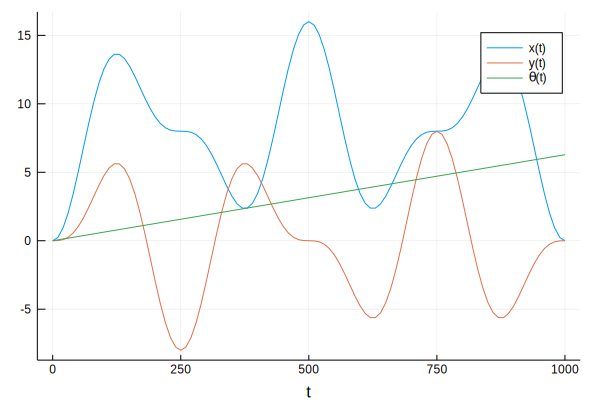

In [6]:
function fRobot(t,u,p)
    L = p[1]
    R = p[2]
    x = u[1]
    y = u[2]      
    theta = u[3]
    vl = (3/5*sin(pi/125*t) - 1/200)
    vr = (3/5*sin(pi/125*t) + 1/200)
    dx =  pi*R*(vl+vr)*cos(theta)
    dy =  pi*R*(vl+vr)*sin(theta)
    dtheta = 2*pi*R*(vr-vl)/L   
    return [dx,dy,dtheta]
end

L = 0.5
R = 0.05
p = [L,R]
u0 = [0.0,0.0,0.0]

T = 1000.0
n=100

res = RK4(u0,0.0,T,n,fRobot,p)
tt = res[:,1]
xx = res[:,2]
yy = res[:,3]

thetas = res[:,4]

plot(tt,[xx, yy,thetas], xlabel="t",label=["x(t)" "y(t)" "\\theta (t)"])

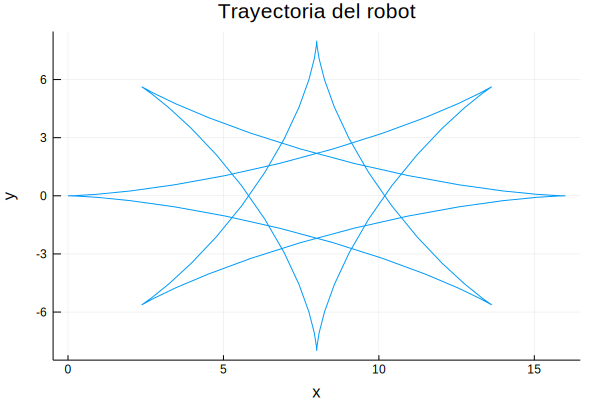

In [7]:
plot(xx, yy, xlabel="x",ylabel="y",label="",title="Trayectoria del robot")

 - **Obtener tres aproximaciones distintas con las longitudes de paso $h=10$, $h=5$, y $h=2.5$ respectivamente, y calcular los errores cometidos en cada caso (tal como se hizo para el método de Euler mejorado en la entrega de la 3ª semana) y representarlos gráficamente en una misma figura.**

In [8]:
function RobotSol(t)
    theta = π*t/500
    c3 = cos(3*theta)
    s3 = sin(3*theta)
    c5 = cos(5*theta)
    s5 = sin(5*theta)
    x = 8 - 5 * c3 - 3 * c5
    y = 5 * s3 - 3 * s5
    return [x, y, theta]
end

function errorRK4(n,m)   
    L = 0.5
    R = 0.05
    p = [L,R]
    u0 = [0.,0.,0.]
    T = 1000
    res = RK4(u0,0.,T,n,fRobot,p,m)
    tt = res[:,1]
    xyzEM = res[:,2:4]    
    errores = zeros(n+1)    
    for j in 1:(n+1)
       errores[j] = norm(xyzEM[j,:]-RobotSol(tt[j]))
    end
    return (tt,errores)
end

errorRK4 (generic function with 1 method)

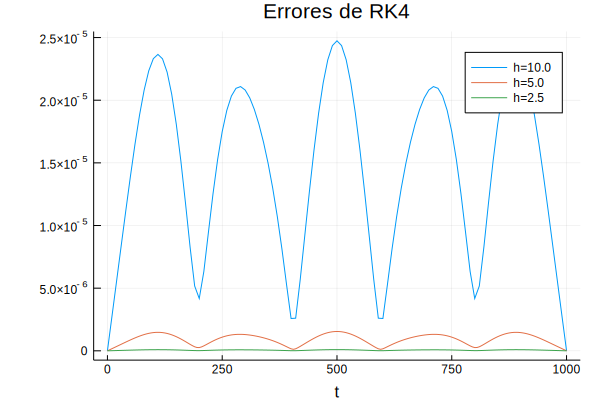

In [9]:
hh = [T/100, T/200, T/400]

(tt, errores) = errorRK4(100,1)
plot(tt,errores,
     title="Errores de RK4", xlabel="t", label=string("h=",hh[1]))

(tt2, errores2) = errorRK4(200,1)
plot!(tt2,errores2, label=string("h=",hh[2]))

(tt4, errores4) = errorRK4(400,1)
plot!(tt4,errores4, label=string("h=",hh[3]))

 - **Obtener una figura con las tres gráficas de los errores divididos por $h^4$.**

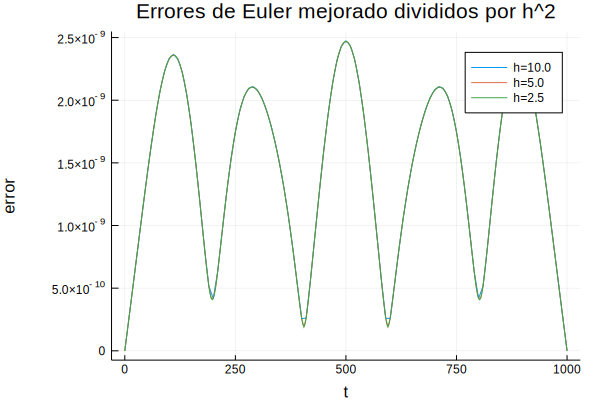

In [10]:
plot(tt,errores/hh[1]^4,
     title="Errores de Euler mejorado divididos por h^2",
     xlabel="t",ylabel="error", label=string("h=",hh[1]))

plot!(tt2,errores2/hh[2]^4, label=string("h=",hh[2]))

plot!(tt4,errores4/hh[3]^4, label=string("h=",hh[3]))

> **Comprobación**
>
>Las tres gráficas de los errores divididas por $h^4$ se deberían superponer aproximadamente (en caso de que no lo sean, señal de que se ha cometido algún fallo), lo que indicaría que los errores son aproximadamente proporcionales a $h^4$. Ello es de esperar, porque RK4 es un método de orden 4. 

<a href="#top">Back to the top</a>

## 3-Satélite artificial orbitando alrededor de la tierra: Modelo simplificado


Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. En el modelo matemático que consideramos seguídamente (propuesto en el siglo XVII por Isaac Newton), se supone para simplificar que la tierra es una esfera con campo gravitacional uniforme. Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según dicho modelo, las coordenadas (respecto del centro de la tierra) $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} x,\\ 
\frac{d^2 y}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} y,\\ 
\frac{d^2 z}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} z,
\end{align*}
    
donde  $\mu$ es la constante gravitacional del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8\, Km^3/s^2.
\end{equation*}

Dicho sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle - \frac{\mu \, x}{(\sqrt{x^2+y^2+z^2})^3} ,\\ 
 \displaystyle - \frac{\mu \, y}{(\sqrt{x^2+y^2+z^2})^3},\\ 
\displaystyle -\frac{\mu \, z}{(\sqrt{x^2+y^2+z^2})^3},
  \end{matrix}
\right).
    \end{align*}


A lo largo del presente ejercicio, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=0,\  \qquad y(0)=37947.73745727695 \, Km,\  \qquad z(0)=0, \\ 
 v_x(0)&=3.297676220718193 \, Km/s, \quad v_y(0)=0, \quad v_z(0)=0.8244190551795483\,  Km/s.
  \end{split}
\end{equation*}

Para dichas condiciones iniciales, se obtiene una _órbita 
geosíncrona_, es decir, una órbita periódica de periodo igual al periodo de rotación de la tierra (23 horas, 56 minutos, y 4 segundos, es decir, un día sidéreo, ligéramente menor que la duración del día solar) que traducido a segundos totales es $T=86164\, s$.  


### 3.1- Ejercicio

- **Aplicar el método RK4 para calcular las coordenadas $(x_k,y_k,z_k)$ del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$ ($T=86164\, s$).  Utilizar $h=T/(4n)=T/4000$ como longitud de paso del método RK4. Obtener una figura con la trayectoria en 3D del satélite alrededor de la tierra.** 

In [11]:
function fsat(t,u,p)
    x = u[1]
    y = u[2]
    z = u[3]
    dx = u[4]
    dy = u[5]
    dz = u[6]
    μ = p[1]
    
    aux = -μ/(norm([x,y,z])^3)
    return [dx, dy, dz, aux*x, aux*y, aux*z]
end

fsat (generic function with 1 method)

In [12]:
u0 = [0.0, 37947.73745727695, 0.0, 3.297676220718193, 0.0 ,0.8244190551795483] 
T = 86164.0
n = 1000
p = [398600.8]

res = RK4(u0,0.0,T,n,fsat,p,4)

1001×7 Array{Float64,2}:
     0.0        0.0         37947.7  …  3.29768   0.0          0.824419
    86.164    284.138       37946.7     3.29759  -0.0238499    0.824397
   172.328    568.261       37943.6     3.29732  -0.0476982    0.82433 
   258.492    852.354       37938.5     3.29687  -0.0715431    0.824218
   344.656   1136.4         37931.3     3.29625  -0.0953829    0.824062
   430.82    1420.38        37922.1  …  3.29544  -0.119216     0.823861
   516.984   1704.29        37910.8     3.29446  -0.143041     0.823616
   603.148   1988.11        37897.4     3.2933   -0.166856     0.823326
   689.312   2271.82        37882.0     3.29196  -0.190658     0.822991
   775.476   2555.4         37864.5     3.29045  -0.214448     0.822612
   861.64    2838.85        37845.0  …  3.28875  -0.238222     0.822189
   947.804   3122.14        37823.5     3.28688  -0.26198      0.821721
  1033.97    3405.26        37799.9     3.28483  -0.28572      0.821209
     ⋮                               ⋱ 

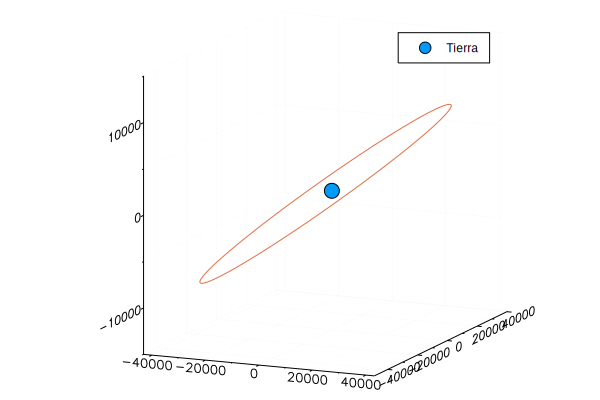

In [13]:
tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
zz = res[:,4]

plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, label="")

- **Guardar las coordenadas $(x_k,y_k,z_k)$ del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$, en un fichero de texto, a tres columnas ($x$ en la primera columna, $y$ en la segunda, $z$ en la tercera). Utilizar el fichero obtenido para realizar una simulación animada del movimiento del satélite orbitando alrededor de la tierra, haciendo uso del codigo JavaScripts que se encuentra en este** <a href="http://www.ehu.eus/ccwmuura/irakaskuntza/sinum/animaciones/tierra_satelite_fichero.html">Fichero html</a>

In [14]:
writedlm("satelliteXYZ.txt",res[:,2:4]," ")

### 3.2-Ejercicio

- **Para aseguraros de que la aproximación numérica es suficientemente precisa, queremos  representar gráficamente la evolucion 
(para $k=1,2,\ldots,1000$) del error  en la posición del satélite**
<a id='Error-posicion'></a>
\begin{equation*}
\sqrt{(x_k -x(t_k))^2+(y_k -y(t_k))^2+(z_k -z(t_k))^2}. \tag{3}
\end{equation*}
**En la práctica, en lugar de tratar de calcular los errores de forma exacta,  calcularemos las estimaciones del error cometido por medio del procedimiento de estimación del error descrito al final de la exposición del Tema~2 (para ello, hay que tener en cuenta que RK4 es un método de orden 4). En el cálculo estimado de los errores en posición del satélite, se obtendrá sustituyendo en [(3)](#Error-posicion) los errores cometidos en cada componente de $(x_k,y_k,z_k)$ por la estimación del error correspondiente.**

In [15]:
print(86164/(4*1e3))# longitud de paso h (m=4)
print("\n")
print(2*(86164/(4*1e3)))# longitud de paso 2h 
print("\n")
print(86164/(2*1e3))# longitud de paso h (m=2)

res2 = RK4(u0,0.,T,n,fsat,p,2)

errores = zeros(size(res2,1),1)
for j in 1:size(res2,1)
    errores[j] = norm(res2[j,2:4]-res[j,2:4])  
end


21.541
43.082
43.082

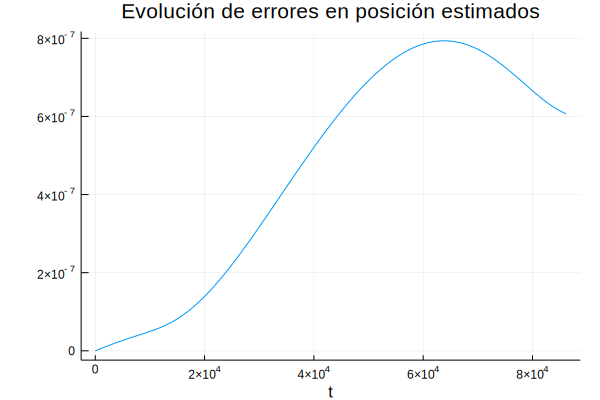

In [16]:
tt = res[:,1]

plot(tt,errores,xlabel="t",label="",title="Evolución de errores en posición estimados")

### 3.3-Ejercicio

- **Se sabe que la solución exacta es periódica, con periodo $T$, de modo que tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta. Comparar dicho error exacto con la estimación obtenida en el apartado anterior para  el tiempo final $t_n=T$.**

In [17]:
print(norm(res[end,2:4]-res[1,2:4])) #error exacto  
print("\n")
print(errores[length(errores)])# estimación obtenida para el tiempo final

errores[length(errores)]/norm(res[size(res2,1),2:4]-res[1,2:4])

3.997939040924638e-8
6.069626188626502e-7

15.181887783918604

- **¿Es dicha estimación del error en $t=T$ de magnitud similar al error cometido realmente?**

>**Respuesta**
>
>La estimacion del error en t=T es 15.2 veces mas alta que el error cometido realmente, es decir es mas que un orden de magnitud mas grande que el error cometido realmente.

<a href="#top">Back to the top</a>

## 4-Satélite artificial orbitando alrededor de la tierra: Modelo más realista

En el apartado anterior, hemos supuesto que la tierra es esférica, cuando en realidad presenta un ligero achatamiendo en ambos polos.  En el modelo matemático que consideramos a continuación, se obtiene una descripción más realista del movimiento del satélite artificial teniendo en cuenta dicho achatamiento. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 y}{dt^2} &= -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 z}{dt^2} &= -\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right),
\end{align*}

donde 
\begin{equation*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{equation*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

Como en el modelo simplificado considerado en el apartado anterior, este sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite.

### 4.1-Ejercicio

- **¿Cuales son las variables de estado?**
- **¿Cuales son los parámetros constantes del problema? **
- **¿Qué variables no son ni variables de estado ni parámetros constantes del problema? (Tales variables son variables auxiliares intermedias utilizadas para definir de forma conveniente las distinas componentes de la aceleración del satélite).**

>**Respuesta**
>
> **Variables de estado:** $(v_x,v_y,v_z)$. El sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite:
>
>\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle  -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right) \\ 
 \displaystyle -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
\displaystyle -\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right)
  \end{matrix}
\right).
    \end{align*}
>
>
> **Parámetros constantes:** la constante gravitacional ($\mu$), el radio ($R$), y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra ($\epsilon$).

> **Variables auxiliares intermedias:** Para definir de forma conveniente las distinas componentes de la aceleración del satélite se utilizan las variables auxiliares intermedias siguientes:
> \begin{align*}
aux1 = 1 + \frac{\epsilon R^2}{r^2}\, F \\ 
aux2 = 1 + \frac{\epsilon R^2}{r^2}\, G 
\end{align*}

### 4.2-Ejercicio

A lo largo del presente ejercicio, consideraremos las mismas condiciones iniciales que en el apartado anterior. Queremos comprobar si, en el caso del modelo más realista, la trayectoria correspondiente sigue siendo periódica, con periodo $T$.


- **Aplicar el método RK4, utilizando $h=T/4000$ como longitud de paso, para calcular las posiciones y velocidades del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$. Calcular la distancia entre las posiciones del satélite en $t=0$ y $t=T$.**

In [18]:
function fsat2(t,u,p)
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    dx = u[4]
    dy = u[5]
    dz = u[6]
    
    # varias líneas de código
    r = norm([x,y,z])
    F = ( 3/2 )-( 15*(z^2) )/( 2*(r^2) )
    G = ( 9/2 )-( 15*(z^2) )/( 2*(r^2) )
    
    aux1 = 1 + ( (ϵ*(R^2))/(r^2) )*F 
    aux2 = 1 + ( (ϵ*(R^2))/(r^2) )*G 
    
    vx = ( (-μ*x)/(r^3) )*aux1
    vy = ( (-μ*y)/(r^3) )*aux1
    vz = ( (-μ*z)/(r^3) )*aux2
    
    return [dx, dy, dz, vx, vy, vz]
end


u0 = [0.0, 37947.73745727695, 0.0, 3.297676220718193, 0.0 ,0.8244190551795483] 
T = 86164.0
n = 1000
p = [398600.8, 6378.135, 0.0010826157]

res = RK4(u0,0.0,T,n,fsat2,p,4)

dist = norm(res[end,2:4]-res[1,2:4])

23.269005340483364

### 4.3-Ejercicio

- Comprobaréis que dicha distancia no es cero. ** ¿Esto será debido al error inherente al método RK4 utilizado, o a que realmente la trayectoria del satélite en el nuevo modelo ya no es periódica con periodo $T$?**

>**Respuesta**
>
>Podemos observar que la distancia no es cero y que ademas corresponde a una distancia de aprox. 23km. Al mismo tiempo, hemos utilizado un modelo mas realista, por lo cual es poco probable que el error inherente al metodo RK4 esta mas alto para el modelo mas realista. Una hipotesis es que teniendo en cuenta las constantes y variables adicionales, la trayectoria del satelite en el nuevo modelo ya no es periodica con periodo T.

### 4.4-Ejercicio

- **Para tratar de responder con más seguridad a la pregunta del punto 4.3, obtener una gráfica de la evolución de los errores de posición estimados, tal como se hizo en el apartado anterior.**

21.541
43.082
43.082
23.269005340483364

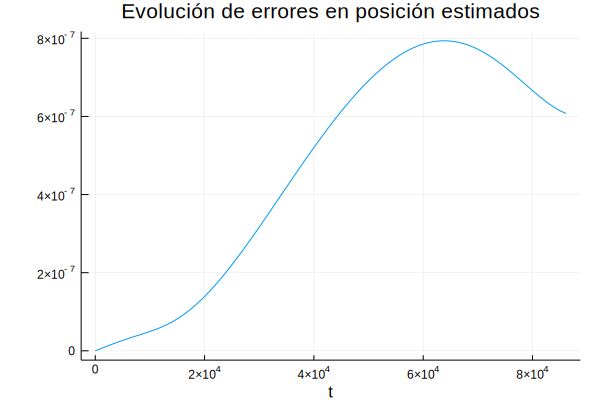

In [35]:
print(86164/(4*1e3))# longitud de paso h (m=4)
print("\n")
print(2*86164/(4*1e3))# longitud de paso 2h (m=4)
print("\n")
print(86164/(2*1e3))# longitud de paso h (m=2)

u0 = [0.0, 37947.73745727695, 0.0, 3.297676220718193, 0.0 ,0.8244190551795483] 
T = 86164.0
n = 1000
p = [398600.8, 6378.135, 0.0010826157]

res = RK4(u0,0.0,T,n,fsat2,p,4)
print("\n")
print(norm(res[end,2:4]-res[1,2:4]))

res2 = RK4(u0,0.0,T,n,fsat2,p,2)

errores = zeros(size(res2,1),1)
for j in 1:size(res2,1)
    errores[j] = norm(res2[j,2:4]-res[j,2:4])  
end

plot(tt,errores,xlabel="t",label="",title="Evolución de errores en posición estimados")

### 4.5-Ejercicio

- ** En vista del tamaño del error estimado, responder de forma razonada si la trayectoria del satélite es periódica de periodo $T$ o no. **

>**Respuesta**
>
>Podemos observar en la evolucion del error estimado que existe una casi-periodicidad, y que se podria aproximar con una funcion de seno. Pero tambien podemos observar que la funcion no es totalmente periodica en el intervalo [0,T]. Por lo cual podemos decir que la trayectoria del satelite no es totalmente periodica de periodo T y que existe una desviacion. Como el error entre t=0 y t=T es de 23km y de orden de magnitude mucho mas alto que el error estimado, es poco probable que esta desviacion es relacionada al error inherente al metodo RK4, pero que refleja una desviacion en la periodicidad de la trayectoria del satelite.

### 4.6-Ejercicio

- **Representar la proyección en el plano OXY (en el plano del ecuador) de la trayectoria del satélite en el intervalo $[0,T]$.**

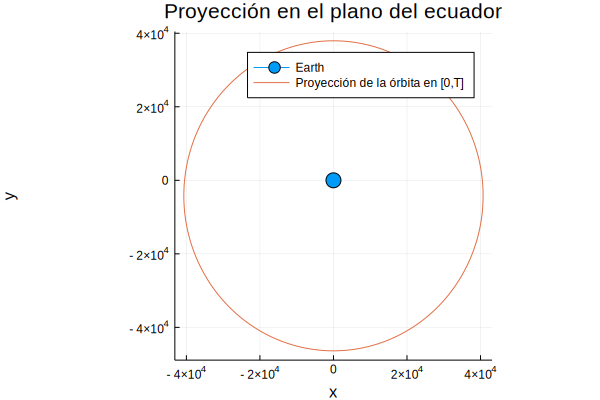

In [20]:
u0 = [0.0, 37947.73745727695, 0.0, 3.297676220718193, 0.0 ,0.8244190551795483] 
T = 86164.0
n = 1000
p = [398600.8, 6378.135, 0.0010826157]

res = RK4(u0,0.,T,n,fsat2,p,4)

tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
zz = res[:,4]

plot([0.],[0.],marker=8,label="Earth")
plot!(xx,yy,xlabel="x", ylabel="y",label="Proyección de la órbita en [0,T]", aspect_ratio=1,
    title="Proyección en el plano del ecuador")

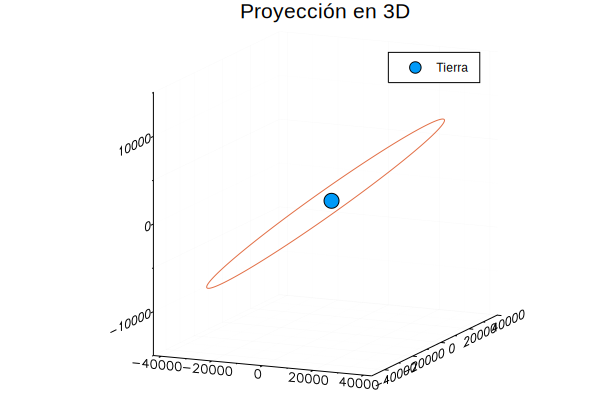

In [21]:
plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, label="",
    title="Proyección en 3D")

- **Aplicar el método RK4  con $h=T/4000$ como longitud de paso, para calcular la posición y velocidad del satélite en $t = 3660\, T$** (es decir, cuando ha transcurrido aproximadamente diez años).

In [22]:
t0 = 0.0
T = 86164.0

h = zeros(3661,1)
t = zeros(3661,2)
for year in 1:3661
   t[year,:] = [t0,t0+T]
   h[year] = (T-t0)/4000
   t0 = t0+T
end
print(unique(h)[1])
print("\n")
print(t0/86164)
print("\n")
print(t[end,:]./86164)

21.541
3661.0
[3660.0, 3661.0]

In [23]:
u0 = [0.0, 37947.73745727695, 0.0, 3.297676220718193, 0.0 ,0.8244190551795483] 
t0 = 0.0

T = 86164.0
n = 1000
p = [398600.8, 6378.135, 0.0010826157]

3-element Array{Float64,1}:
 398600.8         
   6378.135       
      0.0010826157

In [24]:
res3 = 0.0 * zeros(n+1,7)
for year in 1:3661 # para cada dia, de 1 a 3661 (aprox 10 años)
   res3 = RK4(u0,t0,T,n,fsat2,p,4)
   u0 = res3[end,2:7] # actualizacion de la condicion inicial    
   t0 = year*86164.0 # actualizacion de t0
   T = 86164.0*(year+1.0) # actualizacion de T   
end

In [25]:
print(res3[1,1]/86164.0)
print("\n")
print(res3[end,1]/86164.0)

3660.0
3661.0000000003984

In [26]:
# posición y velocidad para t=3660T
print(size(res3))
res3[1,2:7] 

(1001, 7)

6-element Array{Float64,1}:
  34446.809431621885    
 -22000.268208682868    
   1592.278060838746    
     -1.3685705771276941
     -2.7587585977101217
     -0.7431495577691004

>**Comprobación**
>
> La posición y velocidad que obtiene para $t=3660T$ es
> $(x, y, z) = (34446.80929589261,-22000.268482219773,1592.2779871419357)$,
  $( v_x, v_y, v_z) = (-1.3685705970217261, -2.758758585005559, -0.7431495586890531)$

- **Representar la proyección en el plano del ecuador de la trayectoria del satélite en el intervalo $[3660\, T,3661\, T]$. Representarlo en una misma figura junto con la obtenida para el intervalo $[0,T]$, para comparar como cambia la órbita del satélite a lo largo de (aproximadamente) diez años.**

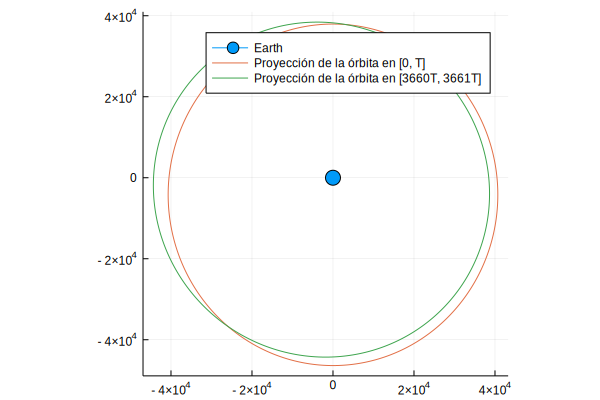

In [27]:
xx = res[:,2]
yy = res[:,3]

xx2 = res3[:,2]
yy2 = res3[:,3]

plot([0.],[0.],marker=8,label="Earth")
plot!(xx,yy,label="Proyección de la órbita en [0, T]", aspect_ratio=1)
plot!(xx2,yy2,label="Proyección de la órbita en [3660T, 3661T]", aspect_ratio=1)

> **Comprobación**
>
> Se deberían obtener dos elipses (casi circulares) giradas una con respecto a la otra. A lo largo del tiempo, la elipse que forma la trayectoria del satélite va girando, un fenómeno que ocurre debido al achatamiento de la tierra en los polos, y que se llama precesión de la órbita.

<a href="#top">Back to the top</a>

### Valoración

_Incluir aquí los comentarios de valoración de la tarea a entregar (dificultad, interés, etc, incluidas, si se quiere, sugerencias de mejora del ejercicio), así como una estimación del tiempo dedicado al trabajo de la semana (desglosado en el tiempo de estudio de material teórico, tiempo de dedicación a la participación activa o pasiva en los foros, tiempo de implementación y experimentación con los problemas prácticos planteados, y tiempo de preparación del documento jupyter final)._

> **dificultad:** atla !!!
>
> **interés**: alto!!! he apprendido mucho !!!
>
> **sugerencias de mejora del ejercicio**: los enunciados parecen a veces dificiles a entender, por ej. me ha cuestado mucho entender lo que habia que hacer en el ejercicio 4.6.
>
>**tiempo dedicado:**
> + tiempo de estudio material teorico: 2h
> + tiempo de dedicacion en el foro: 3h
> + tiempo de implementacion y experimentacion: 15h
> + tiempo de preparacion del documento jupyter: 2h